Iteration 99, Loss: 0.004373707342892885
Iteration 199, Loss: 0.0008717527380213141
Iteration 299, Loss: 0.00038477120688185096
Iteration 399, Loss: 0.00027328639407642186
Iteration 499, Loss: 0.00035097156069241464
Iteration 599, Loss: 0.00019803663599304855
Iteration 699, Loss: 0.0003206803521607071
Iteration 799, Loss: 0.00042286200914531946
Iteration 899, Loss: 0.0010913386940956116
Iteration 999, Loss: 0.00023410265566781163


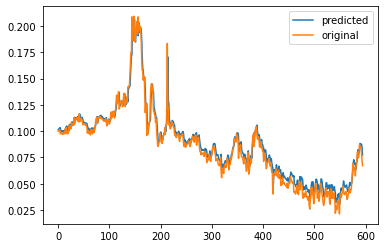

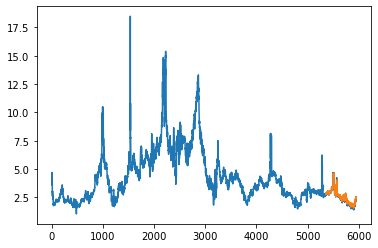

In [34]:
# Q1
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn

# Load the dataset
df = pd.read_csv("daily_csv.csv")

# Preprocess the data - Drop NA values in the dataset
df = df.dropna()
y = df['Price'].values

# Normalize the input range between 0 and 1
minm = y.min()
maxm = y.max()
y = (y - minm) / (maxm - minm)

Sequence_Length = 10
X = []
Y = []

# Prepare the data X[i to i+10] is the input X[i + 11] is the output
for i in range(0, len(y) - Sequence_Length):
    X.append(y[i:i+Sequence_Length])
    Y.append(y[i + Sequence_Length])

X = np.array(X)
Y = np.array(Y)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42, shuffle=False, stratify=None)

class NGTimeSeries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len

# Create DataLoader for training set
train_dataset = NGTimeSeries(x_train, y_train)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=256)

# Create the RNN Model with input size as 1 and hidden_size as 5, with one hidden layer.
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        output, _status = self.rnn(x)
        output = output[:, -1, :]
        output = self.fc1(torch.relu(output))
        return output

model = RNNModel()

# Define optimizer and loss function
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 1000

# Training loop
for i in range(epochs):
    for j, data in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(data[0].view(-1, Sequence_Length, 1))
        loss = criterion(y_pred.view(-1), data[1])
        loss.backward()
        optimizer.step()
    if (i+1)%100==0:
        print(f"Iteration {i}, Loss: {loss.item()}")

# Test set: actual vs predicted
test_set = NGTimeSeries(x_test, y_test)
test_pred = model(test_set[:][0].view(-1, Sequence_Length, 1)).view(-1)

plt.plot(test_pred.detach().numpy(), label='predicted')
plt.plot(test_set[:][1].view(-1), label='original')
plt.legend()
plt.show()

# Undo normalization
y = y * (maxm - minm) + minm
y_pred = test_pred.detach().numpy() * (maxm - minm) + minm
plt.plot(y)
plt.plot(range(len(y)-len(y_pred), len(y)), y_pred)
plt.show()


In [20]:
# Q2
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Korean.txt', 'data/names/Portuguese.txt', 'data/names/Spanish.txt', 'data/names/Czech.txt', 'data/names/Irish.txt', 'data/names/German.txt', 'data/names/Japanese.txt', 'data/names/English.txt', 'data/names/Arabic.txt', 'data/names/Greek.txt', 'data/names/Polish.txt', 'data/names/Italian.txt', 'data/names/Scottish.txt', 'data/names/Russian.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Dutch.txt', 'data/names/French.txt']
Slusarski


In [21]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [22]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [23]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [24]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8539, -2.8428, -2.8479, -2.8015, -2.9258, -2.9044, -2.9815, -2.9446,
         -2.9951, -2.8799, -2.8418, -2.9343, -2.7886, -2.8955, -2.9038, -2.9321,
         -2.9282, -2.8533]], grad_fn=<LogSoftmaxBackward0>)


In [25]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Scottish', 12)


In [26]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Czech / line = Bohunovsky
category = Arabic / line = Shadid
category = English / line = Croft
category = Czech / line = Finferovy
category = Russian / line = Alypov
category = Korean / line = Chong
category = Japanese / line = Iseki
category = Dutch / line = Altena
category = French / line = Firmin
category = French / line = Poingdestre


In [27]:
criterion = nn.NLLLoss()

In [28]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [29]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 1.4026 Sakellariou / Greek ✓
10000 10% (0m 13s) 3.1837 Cann / Chinese ✗ (Dutch)
15000 15% (0m 20s) 1.7832 Maria / Arabic ✗ (Portuguese)
20000 20% (0m 27s) 4.0209 Oorschot / Greek ✗ (Dutch)
25000 25% (0m 34s) 2.0259 Blanc / Scottish ✗ (French)
30000 30% (0m 41s) 1.0872 Staska / Polish ✗ (Czech)
35000 35% (0m 48s) 0.6871 Wei / Chinese ✓
40000 40% (0m 55s) 2.1359 Alphen / Irish ✗ (Dutch)
45000 45% (1m 1s) 0.0446 Assaf / Arabic ✓
50000 50% (1m 8s) 2.4147 Duarte / French ✗ (Portuguese)
55000 55% (1m 14s) 0.6068 Jian / Chinese ✓
60000 60% (1m 21s) 4.1121 Michel / Irish ✗ (Spanish)
65000 65% (1m 28s) 0.0086 Katsepov / Russian ✓
70000 70% (1m 34s) 0.4294 Lefebvre / French ✓
75000 75% (1m 41s) 2.3580 Guillory / Irish ✗ (French)
80000 80% (1m 48s) 2.3105 Meeuwsen / Scottish ✗ (Dutch)
85000 85% (1m 54s) 1.2143 Woolley / English ✓
90000 90% (2m 1s) 1.1369 Haber / Arabic ✗ (German)
95000 95% (2m 8s) 1.4360 Wolter / German ✓
100000 100% (2m 15s) 0.5736 Zhvachkin / Russian ✓


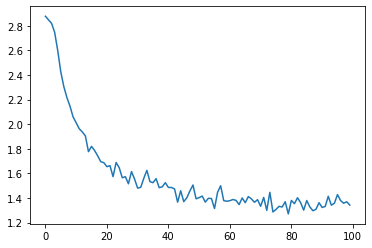

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_6648/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_6648/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


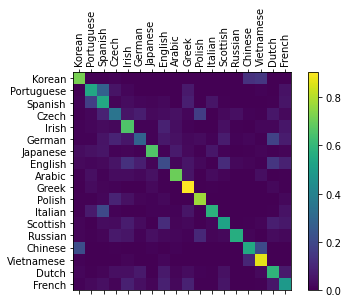

In [31]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [33]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

# predict('')
predict('Jackson')
predict('Satoshi')


> Jackson
(-0.31) Scottish
(-2.02) English
(-3.14) Dutch

> Satoshi
(-1.19) Greek
(-1.28) Italian
(-1.52) Japanese
